In [2]:
import pandas as pd 

## Load & Target Creation:

In [6]:
pth = '/Users/nicholascalen/fnc-1/'
train_bodies = pd.read_csv(pth + 'train_bodies.csv').set_index('Body ID')
train_headlines = pd.read_csv(pth + 'train_stances.csv').set_index('Body ID')
train_all = train_headlines.join(train_bodies)
train_all['target_stage1'] = ''
train_all['target_stage2'] = train_all.Stance
train_all.loc[train_all.Stance == 'unrelated', 'target_stage1'] = 'unrelated'
train_all.loc[train_all.Stance != 'unrelated', 'target_stage1'] = 'related'
train_all.loc[train_all.Stance == 'unrelated', 'target_stage2'] = None
train_all.drop('Stance',inplace=True,axis=1)
train_all.reset_index(inplace=True,drop=True)
train_all.sample(10)

,Headline,articleBody,target_stage1,target_stage2
10762,ISIS Video Purports To Show Beheading Of Briti...,Update at 8:50 p.m. EDT\n\nThe militant group ...,related,discuss
6480,Vogue’s Shiny New Office Has a Big Rat Problem,"(Nov. 26, 2014) – Your Thanksgiving turkey is ...",unrelated,None
3661,DHS Rebuffs Congressman’s Claim ISIS Infiltrat...,"Last year, a Vine from President Obama’s trip ...",unrelated,None
21280,ISIS fighters seize weapons airdrop meant for ...,The United States Department of Defense said o...,related,discuss
11462,"ISIS Claims It Kidnapped Gill Rosenberg, The F...",(KTVI)- An audio recording that allegedly capt...,unrelated,None
45971,Christian Bale quits Steve Jobs movie,"Here at Consumerist HQ, we were both intrigued...",unrelated,None
12226,Apple’s next MacBook could be a 12-inch MacBoo...,The TV streaming services market may be on the...,unrelated,None
35992,Best Christmas present ever? Heartwarming mome...,At least not anytime soon\n\nThe internet has ...,unrelated,None
3200,"Fidel Castro Rumors Sweep Internet, but No Sig...",Variety is reporting that Seth Rogen's got the...,unrelated,None
12881,Catholic Priest Claims God Is Female After Cli...,SYDNEY - An Australian man had a spider remove...,unrelated,None


#### Sample for preprocess refinement / testing: 

In [264]:
sample_train = train_all

In [265]:
sample_train

,Headline,articleBody,target_stage1,target_stage2
0,"Soldier shot, Parliament locked down after gun...",A small meteorite crashed into a wooded area i...,unrelated,None
1,Tourist dubbed ‘Spider Man’ after spider burro...,A small meteorite crashed into a wooded area i...,unrelated,None
2,Luke Somers 'killed in failed rescue attempt i...,A small meteorite crashed into a wooded area i...,unrelated,None
3,BREAKING: Soldier shot at War Memorial in Ottawa,A small meteorite crashed into a wooded area i...,unrelated,None
4,Giant 8ft 9in catfish weighing 19 stone caught...,A small meteorite crashed into a wooded area i...,unrelated,None
...,...,...,...,...
49967,"Pizza delivery man gets tipped more than $2,00...","ANN ARBOR, Mich. – A pizza delivery man in Mic...",related,agree
49968,"Pizza delivery man gets $2,000 tip","ANN ARBOR, Mich. – A pizza delivery man in Mic...",related,agree
49969,"Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip","ANN ARBOR, Mich. – A pizza delivery man in Mic...",related,agree
49970,Ann Arbor pizza delivery driver surprised with...,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",related,agree


## Text Data Cleaning:

In [266]:
def clean_txt(txt):
    # remove punctuation 
    txt=txt.replace("$","")
    txt=txt.replace("#","")

    return txt 

In [267]:
train_all['Headline'] = train_all.Headline.apply(clean_txt)
train_all['articleBody'] = train_all.articleBody.apply(clean_txt)

## Entity Tagging: 

In [130]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 782.7 MB 6.9 kB/s  eta 0:00:01     |███████                         | 173.0 MB 62.0 MB/s eta 0:00:10     |███████████▏                    | 272.3 MB 49.1 MB/s eta 0:00:11     |██████████████                  | 343.6 MB 27.8 MB/s eta 0:00:16     |███████████████▌                | 380.1 MB 19.3 MB/s eta 0:00:21████████████████▉             | 460.3 MB 31.3 MB/s eta 0:00:11�█████████████             | 466.3 MB 1.9 MB/s eta 0:02:49████▏         | 542.5 MB 33.2 MB/s eta 0:00:08     |████████████████████████        | 584.8 MB 43.9 MB/s eta 0:00:05��████████████████▏       | 590.2 MB 43.9 MB/s eta 0:00:05     |████████████████████████▎       | 593.0 MB 43.9 MB/s eta 0:00:05MB/s eta 0:00:03MB/s eta 0:00:02| 705.5 MB 64.5 MB/s eta 0:00:02| 706.4 MB 64.5 MB/s eta 0:00:02��████████████   | 706.8 MB 3.7 MB/s eta 0:00:21 MB 3.7 MB/s eta 0:00:21     |█████████████████████████████▉  | 730.3 MB 3.7 MB/s eta 0:00:15     |██████████████████████████████▍ | 743.1 MB 

In [359]:
import spacy
import en_core_web_lg
import swifter 

nlp = en_core_web_lg.load()

In [308]:

accepted = ['PERSON','NORP','FAC','ORG','GPE','LOC','PRODUCT','EVENT',
           'WORK_OF_ART','LAW','LANGUAGE','DATE','MONEY', 'NOUN','PROPN','NUM']

def noun_tag(text): 
    text = " ".join([x.lemma_ for x in [y 
                                          for y
                                          in nlp(text) 
                                          if not y.is_stop and y.pos_ != 'PUNCT' ]])
    doc = nlp(text)
    return [X.text.lower() for X in doc if X.ent_type_ in accepted or X.pos_ in accepted] 

In [325]:
train_headlines['headline_ents'] = train_headlines['Headline'].swifter.apply(noun_tag) 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/swifter/swifter.py", line 219, in apply
    tmp_df = func(sample, *args, **kwds)
  File "<ipython-input-308-8ceee057f0b8>", line 7, in noun_tag
    in nlp(text)
  File "/opt/anaconda3/lib/python3.7/site-packages/spacy/language.py", line 437, in __call__
    doc = self.make_doc(text)
  File "/opt/anaconda3/lib/python3.7/site-packages/spacy/language.py", line 467, in make_doc
    return self.tokenizer(text)
TypeError: Argument 'string' has incorrect type (expected str, got Series)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-325-49cc0fa39cb3>", line 2, in <module>
    train_headlines['headline_ents'] = train_headlines['Headline'].swifter.apply(noun_tag)
  File "

TypeError: object of type 'NoneType' has no len()

In [309]:
train_bodies['body_ents'] = train_bodies['articleBody'].swifter.apply(noun_tag) 

In [310]:
train_all = train_headlines.join(train_bodies)
train_all['target_stage1'] = ''
train_all['target_stage2'] = train_all.Stance
train_all.loc[train_all.Stance == 'unrelated', 'target_stage1'] = 'unrelated'
train_all.loc[train_all.Stance != 'unrelated', 'target_stage1'] = 'related'
train_all.loc[train_all.Stance == 'unrelated', 'target_stage2'] = None
train_all.drop('Stance',inplace=True,axis=1)
train_all.reset_index(inplace=True,drop=True)

In [328]:
train_all.head()

,Headline,headline_ents,articleBody,body_ents,target_stage1,target_stage2,jaccard_similarity_nouns,pred,headline_ents_t
0,"Soldier shot, Parliament locked down after gun...",soldier parliament gunfire war memorial,A small meteorite crashed into a wooded area i...,"[meteorite, crash, area, nicaragua, capital, m...",unrelated,None,0.0,unrelated,"[soldier, parliament, gunfire, war, memorial]"
1,Tourist dubbed ‘Spider Man’ after spider burro...,tourist spider man spider burrow skin day,A small meteorite crashed into a wooded area i...,"[meteorite, crash, area, nicaragua, capital, m...",unrelated,None,0.0,unrelated,"[tourist, spider, man, spider, burrow, skin, day]"
2,Luke Somers 'killed in failed rescue attempt i...,luke somers rescue attempt yemen,A small meteorite crashed into a wooded area i...,"[meteorite, crash, area, nicaragua, capital, m...",unrelated,None,0.0,unrelated,"[luke, somers, rescue, attempt, yemen]"
3,BREAKING: Soldier shot at War Memorial in Ottawa,soldier war memorial ottawa,A small meteorite crashed into a wooded area i...,"[meteorite, crash, area, nicaragua, capital, m...",unrelated,None,0.0,unrelated,"[soldier, war, memorial, ottawa]"
4,Giant 8ft 9in catfish weighing 19 stone caught...,ft catfish stone italy rod line,A small meteorite crashed into a wooded area i...,"[meteorite, crash, area, nicaragua, capital, m...",unrelated,None,0.0,unrelated,"[ft, catfish, stone, italy, rod, line]"


In [327]:
train_all['headline_ents_t'] = train_all['headline_ents'].apply(lambda x: x.split())

In [761]:
train_all['body_ents'],train_all['headline_ents_t'] 

(0        ['meteorite', 'crash', 'area', 'nicaragua', 'c...
 1        ['meteorite', 'crash', 'area', 'nicaragua', 'c...
 2        ['meteorite', 'crash', 'area', 'nicaragua', 'c...
 3        ['meteorite', 'crash', 'area', 'nicaragua', 'c...
 4        ['meteorite', 'crash', 'area', 'nicaragua', 'c...
                                ...                        
 49967    ['ann', 'arbor', 'michigan', 'pizza', 'deliver...
 49968    ['ann', 'arbor', 'michigan', 'pizza', 'deliver...
 49969    ['ann', 'arbor', 'michigan', 'pizza', 'deliver...
 49970    ['ann', 'arbor', 'michigan', 'pizza', 'deliver...
 49971    ['ann', 'arbor', 'michigan', 'pizza', 'deliver...
 Name: body_ents, Length: 49909, dtype: object,
 0        ['soldier', 'parliament', 'gunfire', 'war', 'm...
 1        ['tourist', 'spider', 'man', 'spider', 'burrow...
 2         ['luke', 'somers', 'rescue', 'attempt', 'yemen']
 3                 ['soldier', 'war', 'memorial', 'ottawa']
 4        ['ft', 'catfish', 'stone', 'italy', 'rod',

In [762]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    if len(union) == 0: 
        return len(intersection)/(len(union) + 1)
    else: 
        return len(intersection)/(len(union))

In [763]:
train_all['jaccard_similarity_nouns'] = train_all.apply(lambda x: jaccard_similarity(x.headline_ents_t, 
                                                                                     x.body_ents), axis=1)

In [764]:
train_all.loc[train_all.target_stage1 =='related','jaccard_similarity_nouns'].min()

0.04

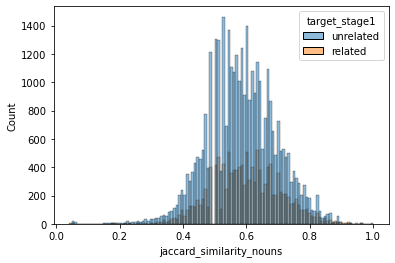

In [765]:
import seaborn as sns 
import matplotlib.pyplot as plt
sns.histplot(train_all, x="jaccard_similarity_nouns", hue="target_stage1", common_norm=True)
#plt.xlim(0, .05)
plt.show() 

In [481]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

In [767]:
from scipy.optimize import minimize_scalar
def objective(threshold): 
    train_all['pred'] ='unrelated'
    train_all.loc[train_all.jaccard_similarity_nouns > threshold, 'pred'] = 'related'
    return -accuracy_score(train_all.target_stage1, train_all.pred)
minimize_scalar(objective,bounds=[0,.2],method='Bounded')['x']

0.1819715841438145

In [738]:
def jaccard_similarity_opt(query, document,token):
    token = int(np.ceil(token))
    intersection = set(query).intersection(set(document[:token]))
    union = set(query).union(set(document[:token]))
    if len(union) == 0: 
        return len(intersection)/(len(union) + 1)
    else: 
        return len(intersection)/(len(union))

def objective(token):
    print(token)
    train_all['jaccard_similarity_nouns'] = train_all.apply(lambda x: jaccard_similarity_opt(x.headline_ents_t, 
                                                                                     x.body_ents, token), axis=1)
    train_all.loc[train_all.jaccard_similarity_nouns > 0.03184318914993509, 'pred'] = 'related'
    return -accuracy_score(train_all.target_stage1, train_all.pred)

minimize_scalar(objective,bounds=[30,150],method='Bounded')

75.83592135001261
104.16407864998737
121.67184270002522
132.49223594996215
139.1796067500631
143.31262919989905
145.86697755016402
147.445651649735
148.421325900429
149.02432574930597
149.397000151123
149.62732559818295


KeyboardInterrupt: 

In [742]:
import numpy as np
def classification_interpretation(y_pred, y_actual): 
    cf_matrix = confusion_matrix(y_actual, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='BuGn',  linewidths=10)


              precision    recall  f1-score   support

     related       0.27      1.00      0.42     13401
   unrelated       0.00      0.00      0.00     36508

    accuracy                           0.27     49909
   macro avg       0.13      0.50      0.21     49909
weighted avg       0.07      0.27      0.11     49909



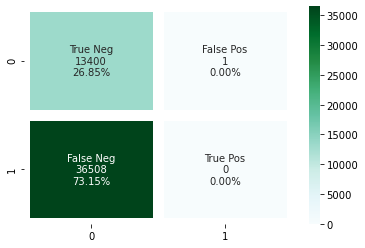

In [743]:
train_all['pred'] ='unrelated'
train_all.loc[train_all.jaccard_similarity_nouns > 0.03184318914993509, 'pred'] = 'related'


cf_matrix = confusion_matrix(train_all.target_stage1, train_all.pred)
classification_interpretation(train_all.pred, train_all.target_stage1)

from sklearn.metrics import classification_report
target_names = ['related', 'unrelated']
print(classification_report(train_all.target_stage1, train_all.pred, target_names=target_names))

In [710]:
from sklearn.metrics import recall_score

In [712]:
mapper = {'unrelated':1,'related':0}

In [714]:
recall_score( train_all.pred.map(mapper), train_all.target_stage1.map(mapper))

0.9857883989182626

In [731]:
wrong = train_all.loc[train_all.target_stage1 != train_all.pred]

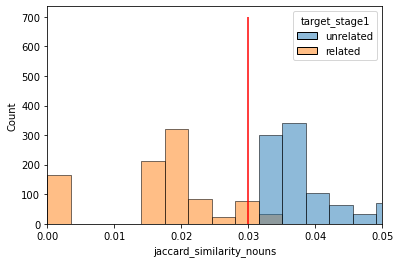

In [659]:
import seaborn as sns 
import matplotlib.pyplot as plt
sns.histplot(wrong, x="jaccard_similarity_nouns", hue="target_stage1", common_norm=True)
plt.vlines(0.03, ymin =0,ymax=700,color='red')
plt.xlim(0, .05)
plt.show() 

In [670]:
wrong.groupby('Headline').count().sort_values('headline_ents')[['headline_ents']]

,headline_ents
Headline,
"Don't forget to tip...especially if you spend $300,000",0
"""Categorically False"": DHS Debunks Right-Wing Fiction That ISIS Attempted To Cross The U.S.- Mexico Border",1
Mystery woman behind the 'richest hands on the internet' revealed: Former pornstar 'makes $5m a year unwrapping Disney toys on YouTube',1
Mum Offers to Sell Twin Boy to Save Twin Girl,1
Moment U.S. Marine is saved by his Kevlar helmet as Taliban sniper bullet hits him in head,1
...,...
"Obama, Outraged Over Beheading, Vows to Stay on Course",16
"Jeh Johnson: Politicians Shouldn't 'Feed The Flames Of Fear' Over ISIS, Ebola",17
ISIL Beheads American Photojournalist in Iraq,18


In [675]:
wrong_isis = wrong.loc[wrong.Headline == 'Missing American journalist reportedly beheaded by Islamic State ']

In [724]:
import nltk
# function for stemming
def get_stem(text):
    stemmer = nltk.porter.PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

In [681]:
wrong_isis.columns

Index(['Unnamed: 0', 'Headline', 'headline_ents', 'articleBody', 'body_ents',
       'target_stage1', 'target_stage2', 'jaccard_similarity_nouns', 'pred',
       'headline_ents_t', 'body_ents_str', 'body_ents_nsw',
       'headline_ents_nsw', 'len_headline', 'len_body', 'total_len',
       'len_body_ents', 'stem_headline'],
      dtype='object')

In [696]:
wrong['stem_body'] = wrong.articleBody.swifter.apply(get_stem)
wrong['stem_body_ents'] = wrong['stem_body'].swifter.apply(noun_tag)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [697]:
wrong['stem_headline'] = wrong.Headline.swifter.apply(get_stem)
wrong['stem_headline_ents'] = wrong['stem_headline'].swifter.apply(noun_tag)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [698]:
wrong['jaccard_similarity_nouns_stem'] = wrong.apply(lambda x: jaccard_similarity(x.stem_headline_ents, 
                                                                                     x.stem_body_ents), axis=1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [701]:
wrong['pred_stem'] ='unrelated'
wrong.loc[wrong.jaccard_similarity_nouns_stem > 0.03184318914993509, 'pred_stem'] = 'related'

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


              precision    recall  f1-score   support

     related       0.34      0.44      0.38       915
   unrelated       0.48      0.38      0.43      1269

    accuracy                           0.40      2184
   macro avg       0.41      0.41      0.40      2184
weighted avg       0.42      0.40      0.41      2184



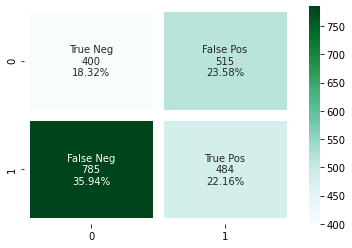

In [702]:
cf_matrix = confusion_matrix(wrong.target_stage1, wrong.pred_stem)
classification_interpretation(wrong.pred_stem, wrong.target_stage1)

from sklearn.metrics import classification_report
target_names = ['related', 'unrelated']
print(classification_report(wrong.target_stage1, wrong.pred_stem, target_names=target_names))

In [704]:
train_all.loc[wrong.index,"pred"] = wrong.pred_stem

#### Pipeline Improvement: Lang Detect

language detection outside the scope of this project. Let's remove non-english examples from the set. 

In [630]:
!pip install langdetect

In [645]:
from langdetect import detect
def detect_lang(txt):
    # look at first 3 words
    #txt = txt.split()[:3]
    return detect(txt)

In [646]:
train_bodies['language'] = train_bodies.articleBody.swifter.apply(detect_lang)

In [647]:
train_all = train_headlines.join(train_bodies)
train_all['target_stage1'] = ''
train_all['target_stage2'] = train_all.Stance
train_all.loc[train_all.Stance == 'unrelated', 'target_stage1'] = 'unrelated'
train_all.loc[train_all.Stance != 'unrelated', 'target_stage1'] = 'related'
train_all.loc[train_all.Stance == 'unrelated', 'target_stage2'] = None
train_all.drop('Stance',inplace=True,axis=1)
train_all.reset_index(inplace=True,drop=True)
train_all.sample(10)

,Headline,headline_ents,articleBody,body_ents,language,target_stage1,target_stage2
9056,“Willie Nelson dead 2015” : Guitarist killed b...,willie nelson guitarist internet death hoax,News of guitarist Willie Nelson’s death spread...,"[news, guitarist, willie, nelson, death, early...",en,related,agree
9137,Daash Ebola transferred to Mosul {Google Trans...,daash ebola mosul google,Two Aussie mates had to be talked out of the g...,"[aussie, mate, honour, world, burger, adelaide...",en,unrelated,None
18461,Saudi fatwa banning snowmen triggers heated de...,fatwa snowman debate,Video: Users of the new iPhone 6 are saying th...,"[video, user, iphone, hair, catch, screen, pho...",en,unrelated,None
37878,Has North Korean dictator Kim Jong-un been rep...,dictator kim jong un sister,"After Stan Beaton's wife, Ruby, passed away in...","[stan, beaton, wife, ruby, 2003, save, leave, ...",en,unrelated,None
39294,US officials: Video shows American's execution,official video american execution,Google has bought about half of Pacific Shores...,"[google, pacific, shores, office, park]",en,unrelated,None
5192,Nigeria: hopes for return of kidnapped schoolg...,nigeria hope return schoolgirl ceasefire,"The 45 year old Mexican/American, born in De l...","[45, year, old, mexican, bear, de, la, cruz, s...",en,unrelated,None
21749,Tropical spider burrowed under Bali tourist's ...,spider bali tourist skin,"Axl Rose is not dead, despite internet reports...","[axl, rose, internet, report, surprise, fan, s...",en,unrelated,None
2396,Report: Nearly a Dozen Commercial Airliners Mi...,report dozen commercial airliner anniversary i...,The Apple Watch was unveiled alongside the iPh...,"[apple, watch, iphone, 6, iphone, september, 9...",en,unrelated,None
442,Will King of Jordan lead airstrikes on ISIS HI...,king jordan airstrike isis report pilot plan a...,An article saying NASA confirmed six days of “...,"[article, nasa, day, darkness, december, itera...",en,unrelated,None
5946,Isis tells mother on rescue mission :’You’ve j...,isis mother rescue mission son,"OTTAWA, Nov 30 (Reuters) - Canada is trying to...","[ottawa, nov, 30, reuters, canada, canadian, c...",en,unrelated,None


In [650]:
bad_lang = train_all.loc[train_all.language!='en'].index

In [653]:
df = pd.read_csv('stg1MSCI598_train.csv')
train_all = df.drop(bad_lang)

In [663]:
len(train_all), len(df)

(49909, 49972)

In [734]:
get_stem('Texas')

'texa'

In [719]:
train_all['headline_ents'].sample(5).swifter.apply(get_stem).apply(lambda x: x.split())

11298    [macaulay, culkin, dead, fan, freak, death, ru...
45558         [luke, somer, sister, yemen, rescu, attempt]
30418         [iphon, appl, watch, samsung, compon, rumor]
44195    [report, taliban, detaine, bow, bergdahl, terror]
14481    [tourist, spider, man, spider, burrow, skin, day]
Name: headline_ents, dtype: object

In [725]:
train_all['headline_ents_stem'] = train_all['headline_ents'].astype(str).swifter.apply(get_stem).apply(lambda x: x.split())
train_all['body_ents_stem'] = train_all['body_ents_str'].astype(str).swifter.apply(get_stem).apply(lambda x: x.split())

In [726]:
train_all['jaccard_similarity_nouns'] = train_all.apply(lambda x: jaccard_similarity(x.headline_ents_stem, 
                                                                                     x.body_ents_stem), axis=1)

In [727]:
minimize_scalar(objective,bounds=[0,.2],method='Bounded')

     fun: -0.9565809773788295
 message: 'Solution found.'
    nfev: 17
  status: 0
 success: True
       x: 0.03236003065007476

In [733]:
wrong

,Unnamed: 0,Headline,headline_ents,articleBody,body_ents,target_stage1,target_stage2,jaccard_similarity_nouns,pred,headline_ents_t,body_ents_str,body_ents_nsw,headline_ents_nsw,len_headline,len_body,total_len,len_body_ents,headline_ents_stem,body_ents_stem
41,41,ISIS fighters 'have contracted Ebola': World H...,isis fighter ebola world health organisation r...,(NEWSER) – Wonder how long a Quarter Pounder w...,"['newser', 'quarter', 'pounder', 'cheese', 'au...",unrelated,NaN,0.032787,related,"['isis', 'fighter', 'ebola', 'world', 'health'...",newser quarter pounder cheese australians mcdo...,"['newser', 'quarter', 'pounder', 'cheese', 'au...","['isis', 'fighter', 'ebola', 'world', 'health'...",19,256,275,84,"[isi, fighter, ebola, world, health, organis, ...","[newser, quarter, pounder, chees, australian, ..."
86,86,HBO and Apple in Talks for $15/Month Apple TV ...,hbo apple talks month apple tv streaming servi...,(NEWSER) – Wonder how long a Quarter Pounder w...,"['newser', 'quarter', 'pounder', 'cheese', 'au...",unrelated,NaN,0.033898,related,"['hbo', 'apple', 'talks', 'month', 'apple', 't...",newser quarter pounder cheese australians mcdo...,"['newser', 'quarter', 'pounder', 'cheese', 'au...","['hbo', 'apple', 'talks', 'month', 'apple', 't...",15,256,271,84,"[hbo, appl, talk, month, appl, tv, stream, ser...","[newser, quarter, pounder, chees, australian, ..."
139,139,6 Islamist militants killed in US attack in So...,militant attack somalia,At least 25 suspected Boko Haram insurgents we...,"['suspect', 'boko', 'haram', 'insurgent', 'cla...",unrelated,NaN,0.037736,related,"['militant', 'attack', 'somalia']",suspect boko haram insurgent clash soldier isl...,"['suspect', 'boko', 'haram', 'insurgent', 'cla...","['militant', 'attack', 'somalia']",9,395,404,143,"[milit, attack, somalia]","[suspect, boko, haram, insurg, clash, soldier,..."
222,222,"No, Saudi TV Didn't Blur Out Michelle Obama's ...",tv blur michelle obama face president met king...,There is so much fake stuff on the Internet in...,"['stuff', 'internet', 'week', 'twitter', 'dhl'...",unrelated,NaN,0.034483,related,"['tv', 'blur', 'michelle', 'obama', 'face', 'p...",stuff internet week twitter dhl ad video jimmy...,"['stuff', 'internet', 'week', 'twitter', 'dhl'...","['tv', 'blur', 'michelle', 'obama', 'face', 'p...",17,1360,1377,440,"[tv, blur, michel, obama, face, presid, met, k...","[stuff, internet, week, twitter, dhl, ad, vide..."
361,361,Texas plumber's truck on front line of Syria war,texas plumber truck line syria war,A SOLDIER has been shot at Canada’s National W...,"['soldier', 'canada', 'national', 'war', 'memo...",unrelated,NaN,0.034483,related,"['texas', 'plumber', 'truck', 'line', 'syria',...",soldier canada national war memorial witness g...,"['soldier', 'canada', 'national', 'war', 'memo...","['texas', 'plumber', 'truck', 'line', 'syria',...",10,67,77,29,"[texa, plumber, truck, line, syria, war]","[soldier, canada, nation, war, memori, wit, gu..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49812,49812,Has a woman aborted her baby because it's a boy?,woman baby boy,"Update: Since the publication of this article,...","['update', 'publication', 'article', 'people',...",related,discuss,0.017857,unrelated,"['woman', 'baby', 'boy']",update publication article people hoax blog ca...,"['update', 'publication', 'article', 'people',...","['woman', 'baby', 'boy']",11,650,661,152,"[woman, babi, boy]","[updat, public, articl, peopl, hoax, blog, cau..."
49822,49822,ISLAMIC STATE BEHEADS MISSING AMERICAN JOURNAL...,state beheads journalist james wright foley,Intelligence agencies hunting for identity of ...,"['intelligence', 'agency', 'hunt', 'identity',...",unrelated,NaN,0.052632,related,"['state', 'beheads', 'journalist', 'james', 'w...",intelligence agency hunt identity murder repor...,"['intelligence', 'agency', 'hunt', 'identity',...","['state', 'beheads', 'journalist', 'james', 'w...",9,907,916,350,"[state, behead, journalist, 

              precision    recall  f1-score   support

     related       0.90      0.94      0.92     13401
   unrelated       0.98      0.96      0.97     36508

    accuracy                           0.96     49909
   macro avg       0.94      0.95      0.95     49909
weighted avg       0.96      0.96      0.96     49909



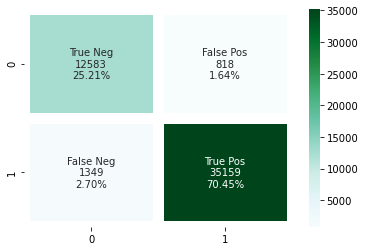

In [728]:
train_all['pred'] ='unrelated'
train_all.loc[train_all.jaccard_similarity_nouns > 0.03236003065007476, 'pred'] = 'related'


cf_matrix = confusion_matrix(train_all.target_stage1, train_all.pred)
classification_interpretation(train_all.pred, train_all.target_stage1)

from sklearn.metrics import classification_report
target_names = ['related', 'unrelated']
print(classification_report(train_all.target_stage1, train_all.pred, target_names=target_names))

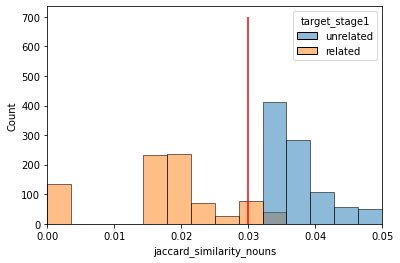

In [732]:
import seaborn as sns 
import matplotlib.pyplot as plt
sns.histplot(wrong, x="jaccard_similarity_nouns", hue="target_stage1", common_norm=True)
plt.vlines(0.03, ymin =0,ymax=700,color='red')
plt.xlim(0, .05)
plt.show() 

In [735]:
accuracy_score(train_all.pred, train_all.target_stage1)

0.9565809773788295

### Output

In [628]:
train_all['body_ents_str'] = train_all['body_ents'].apply(lambda x: " ".join([y for y in x]))

In [629]:
train_all.to_csv("stg1MSCI598_train.csv")

#### Production:

In [ ]:
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

accepted = ['PERSON','NORP','FAC','ORG','GPE','LOC','PRODUCT','EVENT',
           'WORK_OF_ART','LAW','LANGUAGE','DATE','MONEY', 'NOUN','PROPN']

def noun_tag(text): 
    text = " ".join([x.lemma_ for x in [y 
                                          for y
                                          in nlp(text) 
                                          if not y.is_stop and y.pos_ != 'PUNCT' ]])
    doc = nlp(text)
    return [X.text.lower() for X in doc if X.ent_type_ in accepted or X.pos_ in accepted] 

def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    if len(union) == 0: 
        return len(intersection)/(len(union) + 1)
    else: 
        return len(intersection)/(len(union))
    
def inference(headline, body): 
    # clean 
    
    # tag 
    
    # jaccard 
    
    # predict 
    lable = None 
    return label